## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
folder = '/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count) + '.jpg'
  os.rename(source, destination)
  count += 1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = '/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + '.jpg'
  os.rename(source, destination)
  count += 1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


## Exploratory Data Analysis

In [ ]:
list_yes = os.listdir("/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/yes/")
num_yes_files = len(list_yes)
print(f"Number of yes images: {num_yes_files}")

list_no = os.listdir("/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/no/")
num_no_files = len(list_no)
print(f"Number of no images: {num_no_files}")

Number of yes images: 155
Number of no images: 98


### Bar Plot

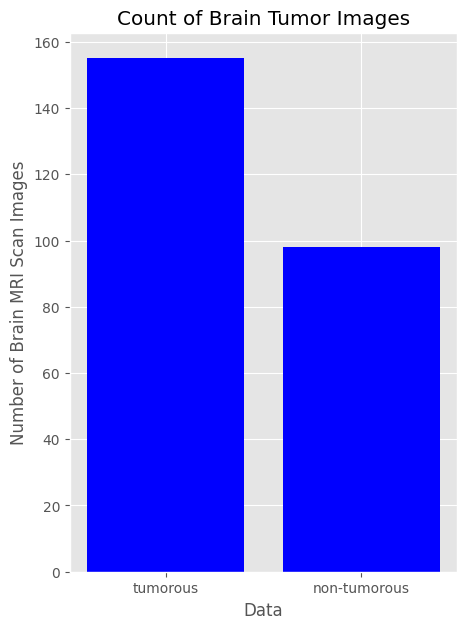

In [ ]:
data = {'tumorous': num_yes_files, 'non-tumorous': num_no_files}

type_x = data.keys()
values = data.values()
fig = plt.figure(figsize = (5,7))
plt.bar(type_x, values, color="blue")
plt.xlabel("Data")
plt.ylabel("Number of Brain MRI Scan Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Augmentation
Due to lack of images, data augmentation is performed.

In [ ]:
def timing(sec_elapsed):
  h = int(sec_elapsed / (60*60))
  m = int(sec_elapsed % (60*60) / 60)
  s = sec_elapsed % 60

  return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       shear_range=0.1,
                       brightness_range=(0.3, 0.1),
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size =1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
          i+=1
          if i>n_generated_samples:
            break

In [ ]:
import time
start_time = time.time()

yes_path = "/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/yes"
no_path = "/content/drive/MyDrive/CSV files/brain_tumor/brain_tumor_dataset/no"

augmented_data_path = "/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/"

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time - start_time
print(f"Elapsed time {timing(execution_time)}")

Elapsed time 0:1:37.89976191520691


In [ ]:
def data_summary(main_path):
    yes_path = "/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/"
    no_path = "/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = n_pos + n_neg

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of samples: {n}")
    print(f"{n_pos} positive samples. Number of positive samples in percentage: {pos_per}%")
    print(f"{n_neg} negative samples. Number of negative samples in percentage: {neg_per}%")

In [ ]:
data_summary(augmented_data_path)

Number of samples: 2065
1085 positive samples. Number of positive samples in percentage: 52.54237288135593%
980 negative samples. Number of negative samples in percentage: 47.45762711864407%


In [ ]:
list_yes = os.listdir("/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/")
num_yes_files = len(list_yes)
print(f"Number of yes images: {num_yes_files}")

list_no = os.listdir("/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/")
num_no_files = len(list_no)
print(f"Number of no images: {num_no_files}")

Number of yes images: 1085
Number of no images: 980


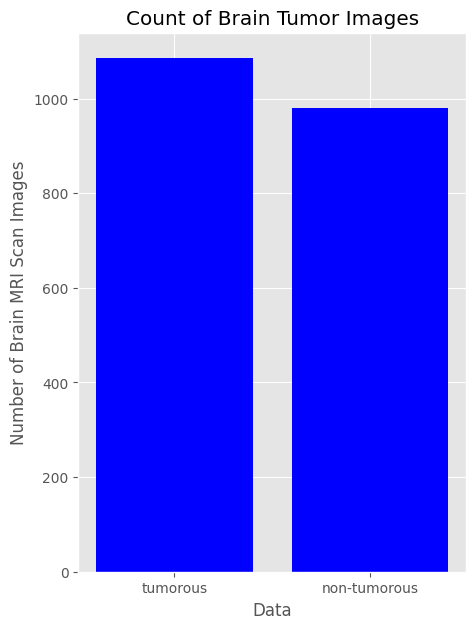

In [ ]:
data = {'tumorous': num_yes_files, 'non-tumorous': num_no_files}

type_x = data.keys()
values = data.values()
fig = plt.figure(figsize = (5,7))
plt.bar(type_x, values, color="blue")
plt.xlabel("Data")
plt.ylabel("Number of Brain MRI Scan Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Preprocessing

In [ ]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [ ]:
!pip install imutils
import imutils
def crop_brain_tumor(image, plot=False):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=597a60d1e6ff62a8f9e1c4022db8ffeb2fd644d7e1da2b77bcf57cdc36d2e4ba
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [ ]:
folder1= '/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/'
folder2= '/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

### Image Loading

In [ ]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot = False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X = np.array(X)
    y = np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of examples is: {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")

    return X,y

In [ ]:
augmented_path = '/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of examples is: 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)


### Data Splitting

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous'):
    base_dir = '/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir,'train')
    os.mkdir(train_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir,'test')
    os.mkdir(test_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir,'valid')
    os.mkdir(valid_dir)

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
original_dataset_tumorous = os.path.join('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data','yes/' )
original_dataset_nontumorous = os.path.join('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data','no/')

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/yes/')
fnames = []
for i in range(922,1085):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('/content/drive/MyDrive/CSV files/brain_tumor/augmented_data/no/')
fnames = []
for i in range(833,980):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

### Model Building

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale = 1.0/255)
valid_data_gen = ImageDataGenerator(rescale = 1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/train', batch_size=128, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/test', batch_size=128, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/CSV files/brain_tumor/tumorous_and_nontumorous/valid', batch_size=128, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

### Callback

In [ ]:
filepath = 'model_h5.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [ ]:
from tensorflow.keras.optimizers.legacy import SGD
adam = Adam(learning_rate=0.001)
model_01.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 20.3082 - accuracy: 0.4996
Epoch 1: val_loss did not improve from 0.66303
10/10 [==============================] - 50s 5s/step - loss: 20.3082 - accuracy: 0.4996 - val_loss: 3.1743 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.5255 - accuracy: 0.5408
Epoch 2: val_loss did not improve from 0.66303
10/10 [==============================] - 48s 5s/step - loss: 1.5255 - accuracy: 0.5408 - val_loss: 0.8974 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.5803
Epoch 3: val_loss did not improve from 0.66303
10/10 [==============================] - 49s 5s/step - loss: 0.7624 - accuracy: 0.5803 - val_loss: 0.8007 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5963
Epoch 4: val_loss did not improve from 0.66303
10/10 [=

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/'):
    os.mkdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/')

model_01.save_weights(filepath='/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_01.h5', overwrite=True)

In [ ]:
model_01.load_weights('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_01.h5')
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

3/3 [==============================] - 10s 3s/step - loss: 0.5729 - accuracy: 0.6613


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Accuracy: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Accuracy: {vgg_test_eval_01[1]}')

Validation Loss: 0.618985116481781
Validation Accuracy: 0.6354838609695435
Testing Loss: 0.5729433298110962
Testing Accuracy: 0.6612903475761414


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose=1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

  3/310 [..............................] - ETA: 13:04

310/310 [==============================] - 10s 17ms/step


### Incremental Unfreezing and Fine Tuning

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.input, output)
model_02.load_weights('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(model_02.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
adam = Adam(learning_rate=0.0001)
model_02.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.6274
Epoch 1: val_loss did not improve from 0.61802
10/10 [==============================] - 55s 6s/step - loss: 0.7466 - accuracy: 0.6274 - val_loss: 0.7247 - val_accuracy: 0.5290 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.7006
Epoch 2: val_loss improved from 0.61802 to 0.57032, saving model to model_h5.keras
10/10 [==============================] - 57s 6s/step - loss: 0.5622 - accuracy: 0.7006 - val_loss: 0.5703 - val_accuracy: 0.6387 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.7729
Epoch 3: val_loss did not improve from 0.57032
10/10 [==============================] - 63s 6s/step - loss: 0.4834 - accuracy: 0.7729 - val_loss: 0.6004 - val_accuracy: 0.6613 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.7965
Epoch 4: 

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/'):
    os.mkdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/')

model_02.save_weights(filepath='/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_02.h5', overwrite=True)

In [ ]:
model_02.load_weights('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_02.h5')
vgg_val_eval_2 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

3/3 [==============================] - 10s 3s/step - loss: 0.3887 - accuracy: 0.8129


### Unfreezing The Entire Network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_03 = Model(base_model.input, output)
model_03.load_weights('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg19_model_02.h5')

adam = Adam(learning_rate=0.0001)
model_03.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
model_03.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs=40, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.5517 
Epoch 1: val_loss did not improve from 0.45796
10/10 [==============================] - 228s 22s/step - loss: 0.7576 - accuracy: 0.5517 - val_loss: 0.6913 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.4945 
Epoch 2: val_loss did not improve from 0.45796
10/10 [==============================] - 238s 24s/step - loss: 0.6950 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5273 
Epoch 3: val_loss did not improve from 0.45796
10/10 [==============================] - 238s 24s/step - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6922 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 4/40
10/10 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5227 
Epoch 4: val_loss did not improve f

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/'):
    os.mkdir('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/')

model_02.save_weights(filepath='/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg_unfrozen.h5', overwrite=True)

In [ ]:
model_03.load_weights('/content/drive/MyDrive/CSV files/brain_tumor/model_weights/vgg_unfrozen.h5')
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)